In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#To download datset from Kaggle:
import kagglehub
from pathlib import Path
import pandas as pd

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")
print("Path to dataset files:", path)

p= Path(path)
df = pd.read_csv(p / "healthcare-dataset-stroke-data.csv")
print(df.head())


Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/stroke-prediction-dataset
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     ne

           count  percent
stroke                   
No stroke   4861    95.13
Stroke       249     4.87
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
        gender          age  hypertension  heart_dise

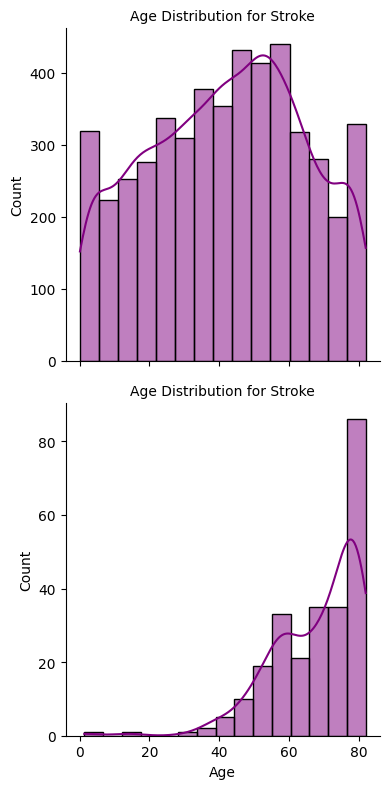

In [ ]:
#PREPROCESSING STEPS
#Create new DataFrame without missing BMI values
df ["bmi"] = df["bmi"].fillna(df["bmi"].median()) #Imputation of BMI values

#Stroke vs No stroke
dist = df["stroke"].value_counts().sort_index()
pct  = (df["stroke"].value_counts(normalize=True).sort_index() * 100).round(2)
summary = pd.DataFrame({"count": dist, "percent": pct}).rename(index={0:"No stroke", 1:"Stroke"})
print(summary)

#Data types and null value info:
df.info()

#Removing dupliactes
df.drop_duplicates(inplace = True)

#Drop ID column
df.drop(columns=['id'], inplace=True, errors='ignore')


#Description of stats
print (df.describe (include = "all"))

#How many missing values exist in each column
print (df.isnull().sum())


#Change categorical data into numerical values
if "gender" in df.columns:
    df = df[df["gender"].isin(["Male", "Female"])].copy()
df.drop(columns=["gender_num"], inplace=True, errors="ignore")

if "gender" in df.columns and not any(c.startswith("gender_") for c in df.columns):
    df = pd.get_dummies(df, columns=["gender"], drop_first=False)

for c in ["gender_Male", "gender_Female"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)







if "ever_married" in df.columns and "is_ever_married" not in df.columns:
  df['is_ever_married'] = df['ever_married'].map({'No':0,'Yes':1})
df.drop(columns=["ever_married"], inplace=True, errors="ignore")
if "Residence_type" in df.columns and "is_urban" not in df.columns:
  df['is_urban'] = df['Residence_type'].map({'Rural':0,'Urban':1})
df.drop(columns=["Residence_type"], inplace=True, errors="ignore")
if "work_type" in df.columns and not any(c.startswith("work_type_") for c in df.columns):
    df = pd.get_dummies(df, columns=["work_type"], drop_first=True)
if "smoking_status" in df.columns and not any(c.startswith("smoking_status_") for c in df.columns):
    df = pd.get_dummies(df, columns=["smoking_status"], drop_first=True)



#To make sure NaN doesn't show up in our binary values:
int_like_cols = ["hypertension", "heart_disease", "stroke",
                 "gender_num", "is_ever_married", "is_urban"]
for col in int_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

#Print overall values
print ("Final columns:", list (df.columns))

#Print missing values
print (df.isnull().sum())

#Checking for class imbalances
if "stroke" in df.columns:
    vc = df["stroke"].value_counts().sort_index() #---> any class imbalances here will be printed as a percentage
    pct = (vc / len(df) * 100). round(2)
    print(pd.DataFrame({"count": vc, "percent": pct}))
else:
    print("column 'stroke' not found.")

#Checking for extremes in the dataset
for col in ["avg_glucose_level", "bmi"]:
    if col in df.columns:
        d = df[col].describe()
        print (f"{col}: min={d['min']: .2f}, 25%={d['25%']:.2f}, median={d['50%']:.2f}, 75%={d['75%']:.2f}, max={d['max']:.2f}")
    else:
        print(f"{col}: not in dataframe")


#Overview of age and gender demographics
if "age" in df.columns:
    d = df["age"].describe()
    print(f"Age --> mean={d['mean']:.2f}, std={d['std']:.2f}, min={d['min']:.2f}, max={d['max']:.2f}")

if "gender" in df.columns: #---> gender here is changed to a % distribution
    print("\nGender distribution (%):")
    print((df["gender"].value_counts(normalize=True) * 100).round(2))

#Top Correlations
num = df.select_dtypes(include="number").copy()
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = corr.where(mask).stack().rename("corr")
print("\nTop 5 strongest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=False).index).head(5).round(3))

print("\nBottom 5 weakest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=True).index).head(5).round(3))


# Create a FacetGrid for multiple histograms
g = sns.FacetGrid(df, col="stroke", col_wrap=1, height=4, sharex=True, sharey=False)
g.map(sns.histplot, "age", kde=True, bins=15, color="purple")

# Add titles
g.set_axis_labels("Age", "Count")
g.set_titles("Age Distribution for Stroke")

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve

)

import matplotlib.pyplot as plt


In [ ]:
#splitting out tragets and features
# Make sure there are no missing values in the target
df = df.dropna(subset=["stroke"])

# Target
y = df["stroke"].astype(int)

# Features: everything except 'stroke'
X = df.drop(columns=["stroke"], errors="ignore")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature columns:", list(X.columns))


X shape: (5109, 16)
y shape: (5109,)
Feature columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 'is_ever_married', 'is_urban', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [ ]:
#training test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

#inverse frequency for class weights
class_counts = y_train.value_counts()
total = len(y_train)
num_classes= len(class_counts)

class_weights = {
    cls: total/ (num_classes * count)
    for cls, count in class_counts.items()
}

print("class counts:", class_counts.to_dict())
print("class weights:", class_weights)

#one-hot encoding done in the preprocessing so do not need to pass cat_features
model = CatBoostClassifier(
    iterations= 800,
    learning_rate=0.03,
    depth = 6,
    loss_function ='Logloss',
    eval_metric= 'AUC',
    class_weights= class_weights,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train,
    y_train,
    eval_set= (X_test, y_test),
    use_best_model = True

)

#The output gives us the training log and AUC per iteration

class counts: {0: 3888, 1: 199}
class weights: {0: 0.5255915637860082, 1: 10.268844221105528}
0:	test: 0.8173663	best: 0.8173663 (0)	total: 71ms	remaining: 56.8s
100:	test: 0.8425926	best: 0.8494547 (11)	total: 874ms	remaining: 6.05s
200:	test: 0.8396296	best: 0.8494547 (11)	total: 1.58s	remaining: 4.72s
300:	test: 0.8371605	best: 0.8494547 (11)	total: 2.24s	remaining: 3.72s
400:	test: 0.8254321	best: 0.8494547 (11)	total: 3s	remaining: 2.98s
500:	test: 0.8165844	best: 0.8494547 (11)	total: 4.02s	remaining: 2.4s
600:	test: 0.8087860	best: 0.8494547 (11)	total: 5.46s	remaining: 1.81s
700:	test: 0.7996708	best: 0.8494547 (11)	total: 6.47s	remaining: 913ms
799:	test: 0.7945885	best: 0.8494547 (11)	total: 6.9s	remaining: 0us

bestTest = 0.8494547325
bestIteration = 11

Shrink model to first 12 iterations.


In [ ]:
#checking for data leaks before cross validation on test split
intersection = set(X_train.index).intersection(set(X_test.index))
print("Number of overlapping rows between train and test:", len(intersection))
assert len(intersection) ==0,  "Data leakage: train and test share rows of data."

Number of overlapping rows between train and test: 0


In [ ]:
#Now that we are sure there is no data leakage, we can cross validation our training data usinf 10-fold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state =42)
fold_aucs = []

for fold, (train_idx, val_idx) in enumerate (skf.split(X_train, y_train), start =1):
  print(f"\n Fold")

  #splitting the training data into inner-train and inner-validation
  X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

  #class weights for the folds
  class_counts_fold = y_tr.value_counts()
  total_fold = len(y_tr)
  num_classes_fold = len(class_counts_fold)

  class_weights_fold = {
      cls: total_fold / (num_classes_fold * count)
      for cls, count in class_counts_fold.items()
  }
  print ("Class counts (train fold):", class_counts_fold.to_dict())
  print("Class weights (train fold):", class_weights_fold)

  #using catboost again but this time to test the model
  model_cv = CatBoostClassifier(
      iterations = 800,
      learning_rate = 0.03,
      depth = 6,
      loss_function= 'Logloss',
      eval_metric='AUC',
      class_weights = class_weights_fold,
      random_seed = 42,
      verbose = False
  )

  model_cv.fit(
      X_tr,
      y_tr,
      eval_set = (X_val, y_val),
      use_best_model= True
  )


  y_val_proba = model_cv.predict_proba(X_val)[:,1]
  fold_auc = roc_auc_score (y_val, y_val_proba)
  fold_aucs.append(fold_auc)

  print (f"Fold {fold} AUC: {fold_auc:.4f}")

  print ("\n 10 fold cross-validation summary on the training set:")
  print ("AUC per fold:", [round(a,4)for a in fold_aucs])
  print (f"Mean AUC: {np.mean (fold_aucs): .4f}")
  print (f"STD AUC: {np.std(fold_aucs): .4f}")



 Fold
Class counts (train fold): {0: 3499, 1: 179}
Class weights (train fold): {0: 0.5255787367819377, 1: 10.273743016759777}
Fold 1 AUC: 0.8640

 10 fold cross-validation summary on the training set:
AUC per fold: [np.float64(0.864)]
Mean AUC:  0.8640
STD AUC:  0.0000

 Fold
Class counts (train fold): {0: 3499, 1: 179}
Class weights (train fold): {0: 0.5255787367819377, 1: 10.273743016759777}
Fold 2 AUC: 0.8676

 10 fold cross-validation summary on the training set:
AUC per fold: [np.float64(0.864), np.float64(0.8676)]
Mean AUC:  0.8658
STD AUC:  0.0018

 Fold
Class counts (train fold): {0: 3499, 1: 179}
Class weights (train fold): {0: 0.5255787367819377, 1: 10.273743016759777}
Fold 3 AUC: 0.8789

 10 fold cross-validation summary on the training set:
AUC per fold: [np.float64(0.864), np.float64(0.8676), np.float64(0.8789)]
Mean AUC:  0.8702
STD AUC:  0.0064

 Fold
Class counts (train fold): {0: 3499, 1: 179}
Class weights (train fold): {0: 0.5255787367819377, 1: 10.273743016759777}


In [ ]:
#Fine-tuned catboost model to optimize performance
tuned_model = CatBoostClassifier(
      iterations = 1000, #more iterations using gradient descent ensure more robust step calculations
      learning_rate = 0.02, #smaller steps for the same reason as above
      depth = 6,
      loss_function= 'Logloss',
      eval_metric='AUC',
      class_weights = class_weights,
      l2_leaf_reg = 7, #L2 normalization
      random_strength = 1, #incase the code is becoming too robust and we're at risk for overfitting
      od_type = "IncToDec",
      od_wait = 50,
      random_seed = 42,
      verbose = 100
)

tuned_model.fit(X_train, y_train)



0:	total: 2.67ms	remaining: 2.67s
100:	total: 268ms	remaining: 2.38s
200:	total: 530ms	remaining: 2.11s
300:	total: 824ms	remaining: 1.91s
400:	total: 1.42s	remaining: 2.12s
500:	total: 1.96s	remaining: 1.95s
600:	total: 2.5s	remaining: 1.66s
700:	total: 3.01s	remaining: 1.28s
800:	total: 3.47s	remaining: 861ms
900:	total: 3.74s	remaining: 411ms
999:	total: 3.98s	remaining: 0us


In [ ]:
#comparing performance between baseline and finetuned catboost models
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

#performance of the baseline model
y_test_proba_base = model.predict_proba(X_test)[:,1]
y_test_pred_base = (y_test_proba_base >= 0.5).astype(int)
base_auc = roc_auc_score(y_test, y_test_proba_base)

print("Baseline Catboost AUC:", base_auc)
print(classification_report(y_test, y_test_pred_base, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_base))

#performance of finetuned model
y_test_proba_tuned = tuned_model.predict_proba(X_test)[:,1]
y_test_pred_tuned = (y_test_proba_tuned >= 0.5).astype(int)
tuned_auc = roc_auc_score(y_test, y_test_proba_tuned)
print("Finetuned Catboost AUC:", tuned_auc)
print(classification_report(y_test, y_test_pred_tuned, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_tuned))


Baseline Catboost AUC: 0.8494547325102879
              precision    recall  f1-score   support

           0     0.9881    0.6831    0.8078       972
           1     0.1200    0.8400    0.2100        50

    accuracy                         0.6908      1022
   macro avg     0.5540    0.7616    0.5089      1022
weighted avg     0.9456    0.6908    0.7785      1022

Confusion matrix:
 [[664 308]
 [  8  42]]
Finetuned Catboost AUC: 0.8028189300411523
              precision    recall  f1-score   support

           0     0.9692    0.9074    0.9373       972
           1     0.1964    0.4400    0.2716        50

    accuracy                         0.8845      1022
   macro avg     0.5828    0.6737    0.6045      1022
weighted avg     0.9314    0.8845    0.9047      1022

Confusion matrix:
 [[882  90]
 [ 28  22]]


In [ ]:
#cross validation to find best threshold value based on the training set (to prevent data leakage)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_aucs = []
fold_thresh = []

beta = 2 #This weights recall more than precision

for fold, (train_idx, val_idx) in enumerate (skf.split(X_train, y_train), start =1):
  print (f"\n Folds:")
  #this part uses the same 80 20 plit for the train
  X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

  class_counts_fold = y_tr.value_counts()
  total_fold = len(y_tr)
  num_classes_fold = len(class_counts_fold)
  class_weights_fold = {
      cls: total_fold / (num_classes_fold * count)
      for cls, count in class_counts_fold.items()
  }
  print("class counts in the training fold:", class_counts_fold.to_dict())
  print("class weights in the traning fold:", class_weights_fold)


#use same values as the fine-tuned CatBoost model
model_cv = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.02,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        class_weights=class_weights_fold,
        l2_leaf_reg=7,
        random_strength=1,
        od_type='IncToDec',
        od_wait=50,
        random_seed=42,
        verbose=100
    )

model_cv.fit(
    X_tr,
    y_tr,
    eval_set = (X_val, y_val),
    use_best_model = True
)

#Evaluations and threshold values for each fold
y_val_proba = model_cv.predict_proba(X_val)[:, 1]
fold_auc = roc_auc_score(y_val, y_val_proba)
fold_aucs.append(fold_auc)
print(f"Fold {fold} AUC: {fold_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

precision_t = precision [:-1]
recall_t = recall [:-1]

fbeta = (1 + beta**2) * (precision_t * recall_t) / (beta**2 * precision_t + recall_t + 1e-8)

best_idx = np.argmax(fbeta)
best_thresh_fold = thresholds[best_idx]
fold_thresh.append(best_thresh_fold)

print (f"Best threshold in fold {fold}: {best_thresh_fold:.3f}")
print ("\n summary on 10 fold cross validation of training set:")
print ("AUCs per fold:", [round(a, 4) for a in fold_aucs])
print(f"Mean AUC: {np.mean(fold_aucs):.4f}")
print(f"Std AUC:  {np.std(fold_aucs):.4f}")
print("Thresholds per fold:", [round(t, 3) for t in fold_thresh])

mean_thresh_from_cv = float(np.mean(fold_thresh))
print(f"\nMean optimal threshold (F2 across folds): {mean_thresh_from_cv:.3f}")



 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016759777}

 Folds:
class counts in the training fold: {0: 3499, 1: 179}
class weights in the traning fold: {0: 0.5255787367819377, 1: 10.273743016

In [ ]:
#model using this optimal threshold
best_thresh = mean_thresh_from_cv
probs= tuned_model.predict_proba(X_test)[:,1]
y_pred_thresh = (probs >= best_thresh).astype(int)

print(f"results with threshold = {best_thresh:.3f}")
print(classification_report (y_test, y_pred_thresh, digits = 4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("Test AUC:", roc_auc_score(y_test, probs))

results with threshold = 0.561
              precision    recall  f1-score   support

           0     0.9690    0.9331    0.9507       972
           1     0.2442    0.4200    0.3088        50

    accuracy                         0.9080      1022
   macro avg     0.6066    0.6766    0.6298      1022
weighted avg     0.9336    0.9080    0.9193      1022

Confusion matrix:
 [[907  65]
 [ 29  21]]
Test AUC: 0.8028189300411523


In [ ]:
#to improve recall, use SMOTE and run the cross validation again
#this will likely increase chances of false positives but that is less dangerous than false negatives in stroke data

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_aucs_sm = []
fold_thresh_sm = []

beta = 2 #This weights recall more than precision

for fold, (train_idx, val_idx) in enumerate (skf.split(X_train, y_train), start =1):
    print (f"\n SMOTE Folds:")
  #this part uses the same 80 20 plit for the train
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

  #applying SMOTE to each fold
    sm = SMOTE (random_state = 42, k_neighbors = 5)

  #Convert Pandas to Numpy
    X_tr_np = X_tr.to_numpy()
    y_tr_np = y_tr.to_numpy().astype(int)

    X_tr_sm_np, y_tr_sm_np = sm.fit_resample(X_tr_np, y_tr_np)

#Convert back to pandas
    X_tr_sm = pd.DataFrame(X_tr_sm_np, columns = X_tr.columns)
    y_tr_sm = pd.Series(y_tr_sm_np, name= y_tr.name)

    print("Fold train counts before SMOTE:", y_tr.value_counts().to_dict())
    print("Fold train counts after SMOTE:", y_tr_sm.value_counts().to_dict())


#use same values as the fine-tuned CatBoost but without weights
    model_cv_sm = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.02,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        l2_leaf_reg=7,
        random_strength=1,
        od_type='IncToDec',
        od_wait=50,
        random_seed=42,
        verbose=100
    )

    model_cv_sm.fit(
       X_tr_sm,
       y_tr_sm,
       eval_set = (X_val, y_val),
       use_best_model = True
)

    y_val_proba = model_cv_sm.predict_proba(X_val)[:,1]
    fold_auc = roc_auc_score(y_val, y_val_proba)
    fold_aucs_sm.append(fold_auc)
    print (f"Fold {fold} AUC (SMOTE): {fold_auc:.4f}")

#Evaluation metrics
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
precision_t = precision[:-1]
recall_t = recall[:-1]
fbeta = (1 + beta**2) * (precision_t * recall_t) / (beta**2 * precision_t + recall_t + 1e-8)

best_idx = np.argmax(fbeta)
best_thresh_fold = thresholds[best_idx]
fold_thresh_sm.append(best_thresh_fold)

print(f"Best threshold in SMOTE fold {fold}: {best_thresh_fold:.3f}")
print ("cross validation summary with SMOTE:")
print (f"Mean AUC with SMOTE: {np.mean(fold_aucs_sm):.4f}")
print (f"STD AUC with SMOTE: {np.std(fold_aucs_sm):.4f}")

print("\nThresholds per fold with SMOTE:", [round(t, 3) for t in fold_thresh_sm])
mean_thresh_from_cv_sm = float(np.mean(fold_thresh_sm))
print(f"\nMean optimal threshold with SMOTE (F2 across folds): {mean_thresh_from_cv_sm:.3f}")




 SMOTE Folds:
Fold train counts before SMOTE: {0: 3499, 1: 179}
Fold train counts after SMOTE: {0: 3499, 1: 3499}
0:	test: 0.8069409	best: 0.8069409 (0)	total: 7.81ms	remaining: 7.81s
100:	test: 0.8336761	best: 0.8353470 (85)	total: 562ms	remaining: 5s
200:	test: 0.8437018	best: 0.8448586 (181)	total: 1.13s	remaining: 4.5s
300:	test: 0.8465296	best: 0.8471722 (298)	total: 1.7s	remaining: 3.95s
400:	test: 0.8519280	best: 0.8526992 (382)	total: 2.26s	remaining: 3.38s
500:	test: 0.8529563	best: 0.8548843 (430)	total: 2.88s	remaining: 2.87s
600:	test: 0.8551414	best: 0.8562982 (531)	total: 3.44s	remaining: 2.29s
700:	test: 0.8593830	best: 0.8597686 (689)	total: 4.02s	remaining: 1.72s
800:	test: 0.8593830	best: 0.8600257 (702)	total: 4.59s	remaining: 1.14s
900:	test: 0.8605398	best: 0.8607969 (873)	total: 5.32s	remaining: 585ms
999:	test: 0.8598972	best: 0.8611825 (986)	total: 6.71s	remaining: 0us

bestTest = 0.8611825193
bestIteration = 986

Shrink model to first 987 iterations.
Fold 1 AU

In [ ]:
#Applying SMOTE to the entire training split
from imblearn.over_sampling import SMOTE
sm = SMOTE (random_state = 42, k_neighbors= 5)
# convert to NumPy to avoid Int64 issues
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().astype(int)

X_train_sm_np, y_train_sm_np = sm.fit_resample(X_train_np, y_train_np)

# back to pandas with normal dtypes
X_train_sm = pd.DataFrame(X_train_sm_np, columns=X_train.columns)
y_train_sm = pd.Series(y_train_sm_np, name=y_train.name)

print("Original y_train counts:")
print(y_train.value_counts())

print("After SMOTE y_train_sm counts:")
print(y_train_sm.value_counts())

#train SMOTE + optimized CatBoost
tuned_model_sm = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.02,
    depth=5, #depth decreases from 6 to 5 to mitigate the risk of overfitting
    loss_function='Logloss',
    eval_metric='AUC',
    l2_leaf_reg=7,
    random_strength=1,
    od_type='IncToDec',
    od_wait=50,
    random_seed=42,
    verbose=100

)

tuned_model_sm.fit(X_train_sm, y_train_sm)

best_thresh = mean_thresh_from_cv_sm
probs_test_sm= tuned_model_sm.predict_proba(X_test)[:,1]
y_pred_test_sm = (probs_test_sm >= best_thresh).astype(int)

print("Final SMOTE model results:")
print(classification_report (y_test, y_pred_test_sm, digits=4))
print("Confusion matrix:", confusion_matrix(y_test, y_pred_test_sm))
print("Test AUC:", roc_auc_score(y_test, probs_test_sm))



Original y_train counts:
stroke
0    3888
1     199
Name: count, dtype: int64
After SMOTE y_train_sm counts:
stroke
0    3888
1    3888
Name: count, dtype: int64
0:	total: 5.87ms	remaining: 5.86s
100:	total: 429ms	remaining: 3.82s
200:	total: 857ms	remaining: 3.41s
300:	total: 1.3s	remaining: 3.03s
400:	total: 2.19s	remaining: 3.28s
500:	total: 2.85s	remaining: 2.84s
600:	total: 3.79s	remaining: 2.52s
700:	total: 4.92s	remaining: 2.1s
800:	total: 5.39s	remaining: 1.34s
900:	total: 5.82s	remaining: 639ms
999:	total: 6.26s	remaining: 0us
Final SMOTE model results:
              precision    recall  f1-score   support

           0     0.9669    0.9012    0.9329       972
           1     0.1724    0.4000    0.2410        50

    accuracy                         0.8767      1022
   macro avg     0.5697    0.6506    0.5869      1022
weighted avg     0.9280    0.8767    0.8991      1022

Confusion matrix: [[876  96]
 [ 30  20]]
Test AUC: 0.7994238683127572
